In [122]:
import os

print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/miawang/ABerg_Audio_Class/UAV_Classification/src/esc50


In [123]:
from configs import load_configs
import yaml
from helper.datamodule_factory import create_datamodule
from icecream import ic
import torch
import numpy as np
import sys
from models.model_factory import ModelFactory
from helper.ptl_trainer import PTLTrainer
from pathlib import Path
from torchinfo import summary

In [ ]:
print("_"*40+"\n")
# Load configuration
with open('../configs/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Change datapath for the sake of the ipynb's pathing
config['dataset']['data_path'] = "../datasets/ESC-50-master/classes"

(general_config, 
    feature_extraction_config,
    dataset_config,  
    peft_config, 
    wandb_config,
    sweep_config, 
    augmentation_config) = load_configs(config)


print("_"*40+"\n")

# Set random seeds for reproducibility
torch.manual_seed(general_config.seed)
torch.cuda.manual_seed(general_config.seed)
np.random.seed(general_config.seed)

# Create data module using the factory
data_module = create_datamodule(
    general_config=general_config,
    feature_extraction_config=feature_extraction_config,
    dataset_config=dataset_config,
    augmentation_config=augmentation_config
)
ic("Created the audio data module")

# Setup data module (this will also save dataloaders if save_dataloader is True)
data_module.setup()
ic("Setup the data module")

ic| 'GeneralConfig instance created successfully:'
ic| 'FeatureExtractionConfig instance created successfully:'
ic| 'DatasetConfig instance created successfully:'
ic| 'PeftConfig instance created successfully:'
ic| 'WandbConfig instance created successfully:'
ic| 'SweepConfig instance created successfully:'
ic| 'AugmentationConfig instance created successfully:'
ic| f"Creating datamodule for dataset type: {dataset_type}": 'Creating datamodule for dataset type: esc50'
ic| 'Creating ESC-50 datamodule'
ic| "Warning: ESC-50 k-fold cross-validation doesn't use separate test sets. test_size will be ignored.": ("Warning: ESC-50 k-fold cross-validation doesn't use separate test sets. "
                                                                                                           'test_size will be ignored.')
ic| "Warning: ESC-50 k-fold cross-validation doesn't use separate inference sets. inference_size will be ignored.": ("Warning: ESC-50 k-fold cross-validation doesn't use separa

________________________________________

________________________________________



ic| 'Created the audio data module'
ic| 'Setting up ESC-50 k-fold cross-validation'


Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv
Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv
Fold 1 (validation): Train: 1600, Val: 400
Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv
Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv
Fold 2 (validation): Train: 1600, Val: 400
Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv
Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv
Fold 3 (validation): Train: 1600, Val: 400
Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv
Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv
Fold 4 (validation): Train: 1600, Val: 400
Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv
Loaded ESC-50 metadata from: ../datasets/ESC-50-master/meta/esc50.csv


ic| f"K-fold setup complete - {len(self.fold_datasets)} folds created": 'K-fold setup complete - 5 folds created'
ic| f"Set to fold {fold_idx+1}: Train: {len(self.train_dataset)}, Val: {len(self.val_dataset)}": 'Set to fold 1: Train: 1600, Val: 400'
ic| f"ESC-50 datasets created in {dataset_init_time:.2f} seconds": 'ESC-50 datasets created in 11.93 seconds'
ic| 'Setup the data module'


Fold 5 (validation): Train: 1600, Val: 400


'Setup the data module'

In [125]:
data_module.train_dataloader().dataset.get_classes()
# data_module.val_dataloader().dataset

['airplane',
 'breathing',
 'brushing_teeth',
 'can_opening',
 'car_horn',
 'cat',
 'chainsaw',
 'chirping_birds',
 'church_bells',
 'clapping',
 'clock_alarm',
 'clock_tick',
 'coughing',
 'cow',
 'crackling_fire',
 'crickets',
 'crow',
 'crying_baby',
 'dog',
 'door_wood_creaks',
 'door_wood_knock',
 'drinking_sipping',
 'engine',
 'fireworks',
 'footsteps',
 'frog',
 'glass_breaking',
 'hand_saw',
 'helicopter',
 'hen',
 'insects',
 'keyboard_typing',
 'laughing',
 'mouse_click',
 'pig',
 'pouring_water',
 'rain',
 'rooster',
 'sea_waves',
 'sheep',
 'siren',
 'sneezing',
 'snoring',
 'thunderstorm',
 'toilet_flush',
 'train',
 'vacuum_cleaner',
 'washing_machine',
 'water_drops',
 'wind']

ic| "sample's class: ", class_index: 7
ic| "sample's input shape: ": "sample's input shape: "
    sample_input.shape: torch.Size([128, 157])
ic| "sample's path: ": "sample's path: "
    data_module.train_dataloader().dataset.paths[idx]: '../datasets/ESC-50-master/classes/chirping_birds/4-187769-A-14.wav'


(1, 80000)


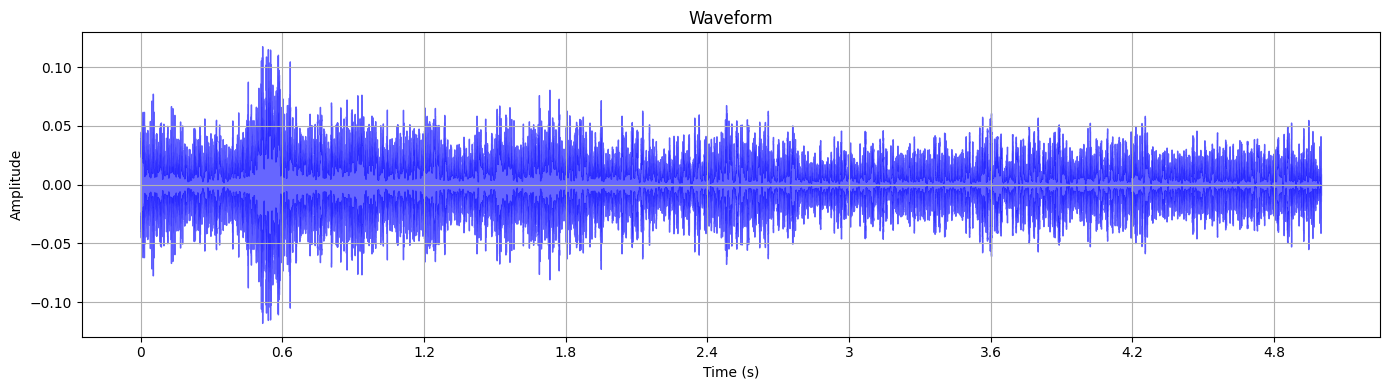

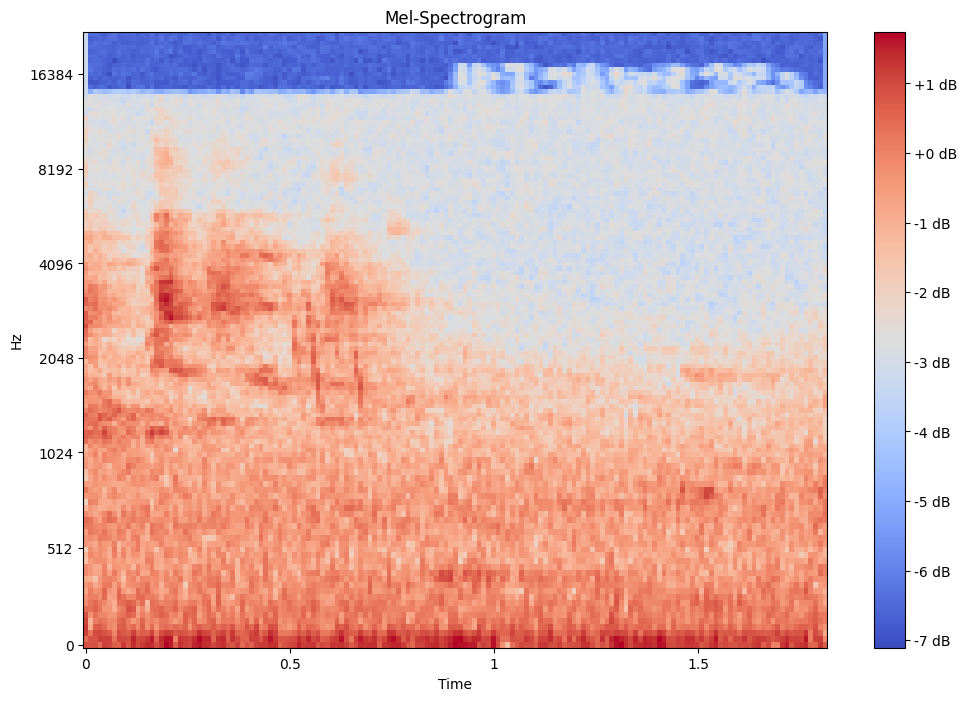

In [126]:
import librosa
import matplotlib.pyplot as plt
idx = 60
# class_map = data_module.train_dataloader().dataset.idx_to_class
# ic("sample's class: ", class_map[idx])
# sample_input, class = data_module.train_dataloader().dataset[idx]
sample_input, class_index = data_module.train_dataloader().dataset[idx]

audio = data_module.train_dataloader().dataset.audio_tensors[idx]
sample_input = sample_input.squeeze(0)  # remove batch dimension if needed
ic("sample's class: ", class_index)
ic("sample's input shape: ", sample_input.shape)
ic("sample's path: ", data_module.train_dataloader().dataset.paths[idx])
sr = 16000
raw_audio = audio.numpy()  # Convert to numpy array if it's a tensor
print(raw_audio.shape)
# Calculate the maximum amplitude across both audio signals
max_amplitude = ((np.abs(raw_audio)))

plt.figure(figsize=(14, 4))
librosa.display.waveshow(raw_audio, sr=sr, alpha=0.6, color='b')
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.grid(True)
plt.show()

data_module.train_dataloader().dataset.show_spectrogram(sample_input)

In [ ]:
# Get a sample from the dataset
# features, class_index = dataset[0]  # Returns (features, class_index)

features, class_index = data_module.train_dataloader().dataset[]

# The class_index is the numerical label (e.g., 0, 1, 2, etc.)
print(f"Class index: {class_index}")

Class index: 16


In [92]:
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import torchaudio.transforms as T
from audiomentations import (
    AddGaussianNoise,
    AddGaussianSNR,
    Gain,
    GainTransition,
    HighPassFilter,
    LowPassFilter,
    BandPassFilter,
    BandStopFilter,
    ClippingDistortion,
    Clip,
    Normalize,
    PitchShift,
    PolarityInversion,
    Resample,
    Reverse,
    Shift,
    TanhDistortion,
    TimeMask,
    TimeStretch,
    Trim,
    Limiter,
    Mp3Compression,

)

# Publically available audio sample of Phantom Pro 4
# Clipped to 5 seconds
# Source: https://freesound.org/people/DCPoke/sounds/387984/
FILE_NAME = "../datasets/ESC-50-master/classes/chirping_birds/1-46040-A-14.wav"

def load_wav(path):
    waveform, sample_rate = torchaudio.load(path)
    return waveform.numpy(), sample_rate

def plot_waveforms_comparison(original_audio, augmented_audio, sr, title1="Original", title2="Augmented", color1='blue', color2='red'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Calculate the maximum amplitude across both audio signals
    max_amplitude = max(np.max(np.abs(original_audio)), np.max(np.abs(augmented_audio)))

    # Plot original audio
    librosa.display.waveshow(original_audio, sr=sr, ax=ax1, color=color1)
    ax1.set_title(title1)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax1.set_ylim(-max_amplitude, max_amplitude)

    # Plot augmented audio
    librosa.display.waveshow(augmented_audio, sr=sr, ax=ax2, color=color2)
    ax2.set_title(title2)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Amplitude')
    ax2.set_ylim(-max_amplitude, max_amplitude)

    plt.tight_layout()
    plt.show()

def plot_waveforms_overlay(original_audio, augmented_audio, sr, title="Original vs Augmented"):
    fig, ax = plt.subplots(figsize=(10, 4))

    # Calculate the maximum amplitude across both audio signals
    max_amplitude = max(np.max(np.abs(original_audio)), np.max(np.abs(augmented_audio)))

    # Plot original audio
    librosa.display.waveshow(original_audio, sr=sr, ax=ax, color='blue', alpha=0.7, label='Original')

    # Plot augmented audio
    librosa.display.waveshow(augmented_audio, sr=sr, ax=ax, color='red', alpha=0.5, label='Augmented')

    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_ylim(-max_amplitude, max_amplitude)
    ax.legend()

    plt.tight_layout()
    plt.show()

def apply_and_visualize_transform(transform, file_name=FILE_NAME):
    # Load audio and sample rate (sr) and display
    audio, sr = load_wav(file_name)
    print("Original Audio:")
    display(ipd.Audio(audio, rate=sr))

    # Transform audio and display
    augmented_audio = transform(audio, sample_rate=int(sr))
    print("Augmented Audio:")
    display(ipd.Audio(augmented_audio, rate=sr))

    # Cross correlate audio samples
    max_corr, lag = cross_correlation(audio, augmented_audio)

    print(f"Maximum correlation: {max_corr:.4f}")
    print(f"Lag: {lag} samples")
    print(f"Lag Time: {lag/sr:.4f} seconds")
    
    # Plot the two .wav samples
    plot_waveforms_comparison(audio, augmented_audio, sr, color1='navy', color2='darkred')

    # Plot the overlay comparison
    plot_waveforms_overlay(audio, augmented_audio, sr)

def cross_correlation(audio1, audio2):
    """
    Compute the cross-correlation between two audio signals.
    
    :param audio1: First audio signal (numpy array)
    :param audio2: Second audio signal (numpy array)
    :return: Maximum correlation value and the corresponding lag
    """
    # Ensure both arrays are 1D
    audio1 = audio1.flatten()
    audio2 = audio2.flatten()
    
    # Compute cross-correlation
    correlation = np.correlate(audio1, audio2, mode='full')
    
    # Find the index of maximum correlation
    max_corr_index = np.argmax(np.abs(correlation))
    
    # Calculate the lag
    lag = max_corr_index - (len(audio1) - 1)
    
    # Normalize the maximum correlation value
    max_corr_value = correlation[max_corr_index] / (np.linalg.norm(audio1) * np.linalg.norm(audio2))
    
    return max_corr_value, lag




Original Audio:


Augmented Audio:


Maximum correlation: 0.0167
Lag: -12933 samples
Lag Time: -0.2933 seconds


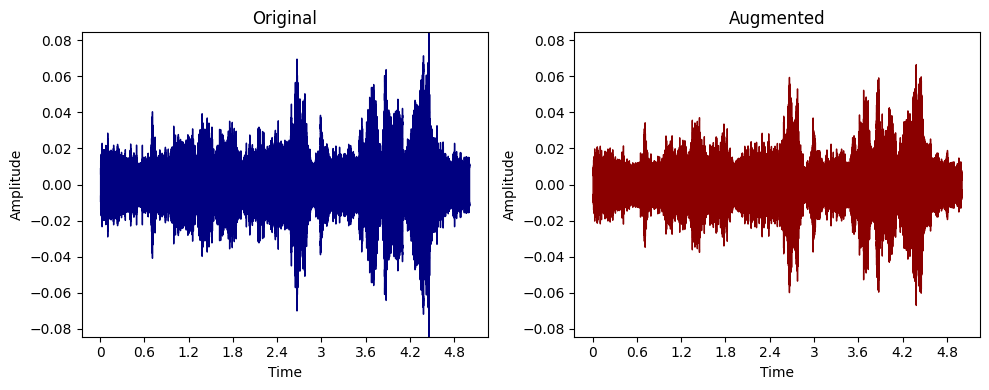

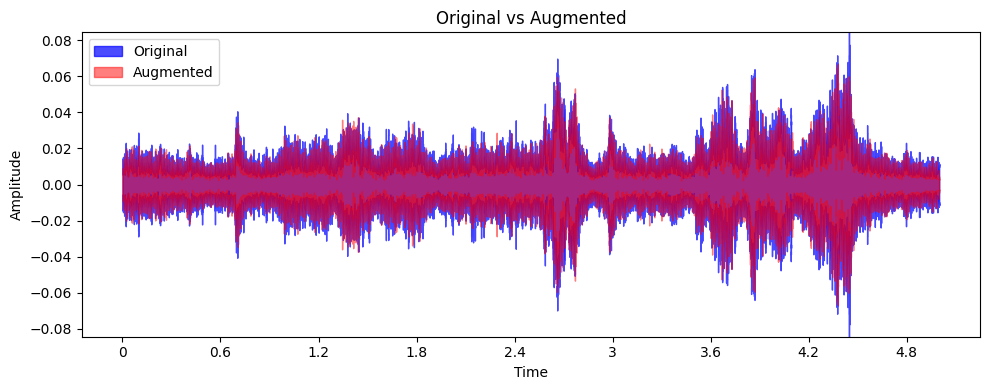

In [93]:
# build PitchShift Transform
transform = PitchShift(   # One octave == 12 semtones
    min_semitones=-12.0,  # Minimum pitch shift in semitones 
    max_semitones=12.0,   # Maximum pitch shift in semitones 
    p=1.0                 # Probability of applying this transform (always applied)
)
apply_and_visualize_transform(transform)